# 2.Problem Statement
In this assignment students will build the random forest model after
normalizing the variable to house pricing from boston data set.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn import tree, datasets
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [2]:
boston = datasets.load_boston() 
features = pd.DataFrame(boston.data, columns=boston.feature_names) 
targets = boston.target

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
df_x = pd.DataFrame(boston.data, columns=boston.feature_names)
df_y = boston.target

In [8]:
df_x.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


# Data Preprocessing
Function to handle missing data

In [9]:
def data_preprocessing(df):
    df.convert_objects(convert_numeric=True)
    df.fillna(0, inplace=True) 
    
    return df

# Function to handle categorical data

In [10]:
def handle_non_numeric_data(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            
            x = 0            
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1                    
            df[column] = list(map(convert_to_int, df[column]))
            
    return df

# Perform data preprocessing on boston dataset

In [11]:
df_x = data_preprocessing(df_x)
df_x = handle_non_numeric_data(df_x)
df_x.head()

C:\Users\Anu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


# Spliting boston dataset into test and traning datase

In [12]:
x_train,x_test,y_train,y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=5)


# Apply RandomForest Model on boston dataset

In [13]:
rfc1 = RandomForestRegressor(random_state=10)
rfc1.fit(x_train, y_train)

C:\Users\Anu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [14]:
#Applying model by changing the max_features parameter
rfc2 = RandomForestRegressor(max_features=8, random_state=10)
rfc2.fit(x_train, y_train)

rfc3 = RandomForestRegressor(max_features=6, random_state=10)
rfc3.fit(x_train, y_train)

C:\Users\Anu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Anu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

# Feature engineering
Analyze features importance

In [15]:
rfc1.feature_importances_

array([0.05492055, 0.00108665, 0.00574825, 0.00511993, 0.00889295,
       0.34557121, 0.01192751, 0.08394476, 0.00816924, 0.01751805,
       0.00749098, 0.01011708, 0.43949285])

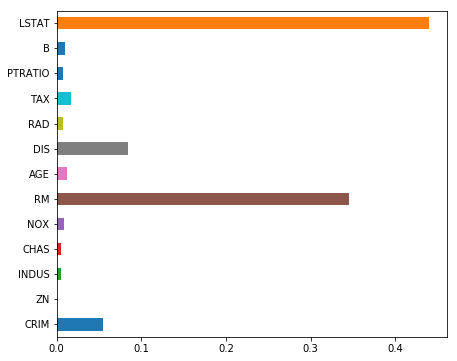

In [16]:
%matplotlib inline
feature_importances = pd.Series(rfc1.feature_importances_,index=df_x.columns)
feature_importances.plot(kind='barh',figsize=(7,6))

C:\Users\Anu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


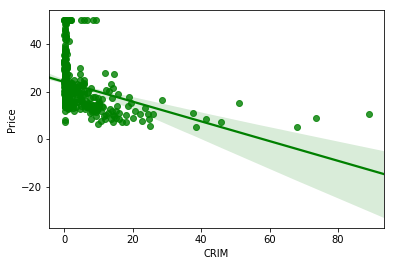

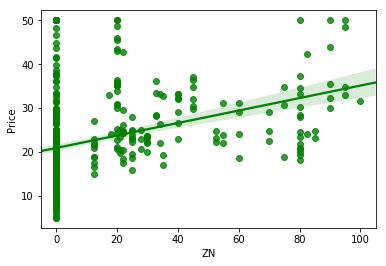

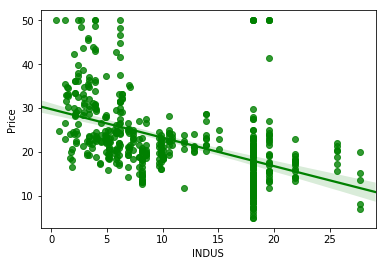

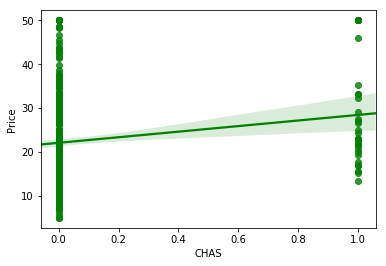

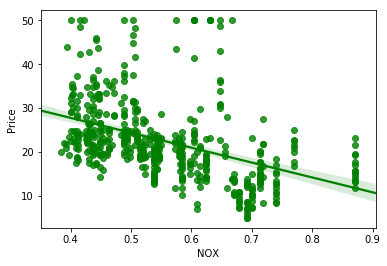

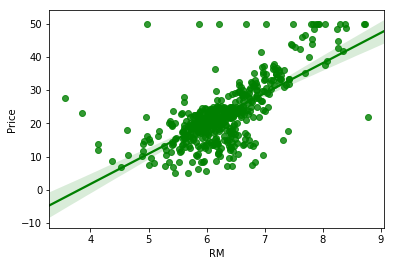

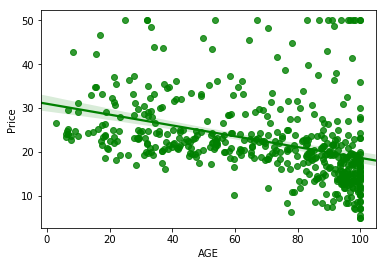

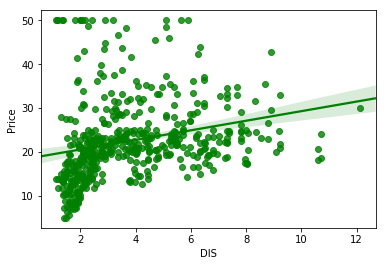

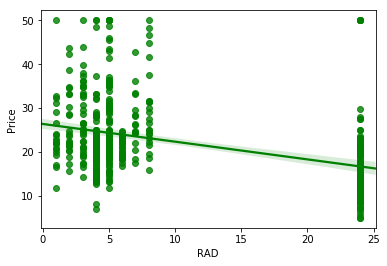

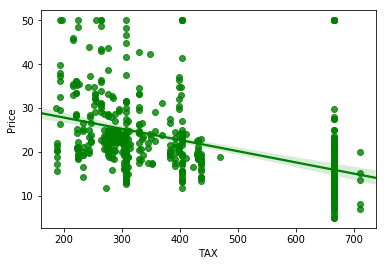

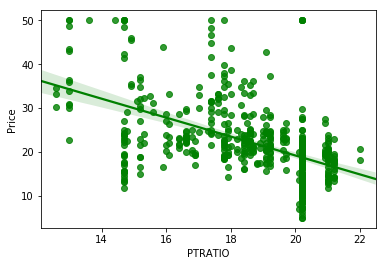

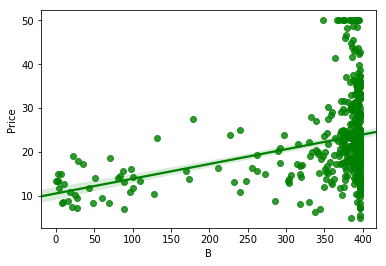

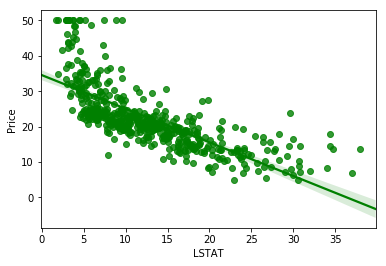

In [17]:
#Graph between features and target price
for var in boston.feature_names:
    sns.regplot(features[var], targets, color='g')
    plt.ylabel('Price')
    plt.show()

# Model Evaluation
Model efficiency by considering all the parameters of boston dataset for analysis

In [18]:
pred1 = rfc1.predict(x_test)
# The mean squared error
print("Mean squared error: %f" % mean_squared_error(y_test, pred1))
# Explained variance score: 1 is perfect prediction
print('Variance score: %f' % r2_score(y_test, pred1))

Mean squared error: 14.593798
Variance score: 0.813602


# Model efficiency by considering n most important features (n=8) of boston dataset for analysis

In [19]:
pred2 = rfc2.predict(x_test)
# The mean squared error
print("Mean squared error: %f" % mean_squared_error(y_test, pred2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %f' % r2_score(y_test, pred2))

Mean squared error: 12.124686
Variance score: 0.845139


Model efficiency by considering n most important features (n=6) of boston dataset for analysis

In [21]:
pred3 = rfc3.predict(x_test)
# The mean squared error
print("Mean squared error: %f" % mean_squared_error(y_test, pred3))
# Explained variance score: 1 is perfect prediction
print('Variance score: %f' % r2_score(y_test, pred3))

Mean squared error: 10.278523
Variance score: 0.868719


# Data Normalization and model evaluation

In [22]:
from sklearn.preprocessing import StandardScaler
scalerx = StandardScaler().fit(x_train)
scalery = StandardScaler().fit(y_train.reshape(-1, 1))

x_train1 = scalerx.transform(x_train)
y_train1 = scalery.transform(y_train.reshape(-1, 1))
x_test1 = scalerx.transform(x_test)
y_test1 = scalery.transform(y_test.reshape(-1, 1))

#print (np.max(x_train1), np.min(x_train1), np.mean(x_train1), np.max(y_train1), np.min(y_train1), np.mean(y_train1))

# Best Model accuracy was provided when we were using 6 features, 
# So Normalized data is given as input into RandomForestRegressor with  max_features=6
rfc4 = RandomForestRegressor(max_features=6, random_state=10)
rfc4.fit(x_train1, y_train1)
pred4 = rfc4.predict(x_test1)
# The mean squared error
print("Mean squared error after normalizing data with 6 features: %f" % mean_squared_error(y_test1, pred4))
# Explained variance score: 1 is perfect prediction
print('Variance score after normalizing data with 6 features: %f' % r2_score(y_test1, pred4))

Mean squared error after normalizing data with 6 features: 0.109291
Variance score after normalizing data with 6 features: 0.880089


C:\Users\Anu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Anu\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


# Visulization between predicted and actual price

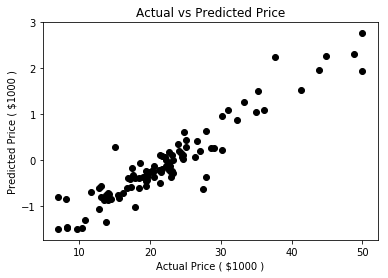

In [23]:
#Between y_test (actual price) and predicted price (pred4)
plt.xlabel("Actual Price ( $1000 )")
plt.ylabel("Predicted Price ( $1000 )")
plt.title("Actual vs Predicted Price")
plt.scatter(y_test, pred4, color='black')
plt.show()